# Predicting Discharge Reference Capacity using Voltage Rebound Information 

**NOTE**: Using parameters estimated from a logisitic-like function fit on the rebound curve, as well as max measured temp in celsius.

**NOTE**: This analysis does not take into account a cell's cycle history, therefore time is not a predictor and is not considered in this analysis.

**NOTE**: Definitions for logisitc-like estimated parameters:
  
*  L: Asymptotic maximum value  
*  A: Scaling factor  
*  x0: Midpoint of the curve  
*  b: Growth rate  

In [1]:
# load packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
n45_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa45_WORSTsubset120.csv')
n47_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa47_WORSTsubset120.csv')
n48_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa48_WORSTsubset120.csv')

In [3]:
n_all = pd.concat([n45_sub, n47_sub, n48_sub], axis = 0)

In [4]:
print(n_all.shape)

(207, 8)


In [5]:
n_all.head()

Step         L         A         x0         b  Reference Capacity  \
0   0.0  3.540956  1.551228  12.993815  0.935087            4356.636   
1   4.0  3.510232  1.523535  11.585284  1.079811            3856.567   
2   6.0  3.498386  1.510713  10.834471  1.172994            3703.252   
3   8.0  3.477645  1.508913  10.580435  1.232048            3594.173   
4  10.0  3.482527  1.499790  10.395401  1.219776            3506.276   

   Max_Temp  Ambient_Temperature  
0    15.710                  4.0  
1    16.327                  4.0  
2    16.190                  4.0  
3    16.445                  4.0  
4    16.652                  4.0

In [6]:
n_all = n_all.drop(columns = ['Ambient_Temperature', 'Step', 'Max_Temp'])

In [7]:
n_all.isnull().sum()

L                     0
A                     0
x0                    0
b                     0
Reference Capacity    0
dtype: int64

In [8]:
n_all = n_all.dropna()

In [9]:
n_all.duplicated().any()

False

In [10]:
n_all.head()

L         A         x0         b  Reference Capacity
0  3.540956  1.551228  12.993815  0.935087            4356.636
1  3.510232  1.523535  11.585284  1.079811            3856.567
2  3.498386  1.510713  10.834471  1.172994            3703.252
3  3.477645  1.508913  10.580435  1.232048            3594.173
4  3.482527  1.499790  10.395401  1.219776            3506.276

In [11]:
n_all.tail()

L         A         x0         b  Reference Capacity
63  4.010738  1.324746  78.508195  0.435464            4679.544
64  3.761847  1.062848  29.368878  0.507540            4568.834
65  3.198999  0.508999   0.308223  5.962126            4519.852
66  3.190154  0.506154   7.791413  3.232986            4507.155
67  3.207044  0.517044   7.870066  3.238898            4403.258

In [12]:
n_all.describe()

L           A          x0           b  Reference Capacity
count  207.000000  207.000000  207.000000  207.000000          207.000000
mean     3.796247    1.414335   44.850071    0.727544         4099.555184
std      0.260102    0.200808   40.920665    0.554472          867.215342
min      3.190154    0.506154    0.308223    0.337659         2678.509000
25%      3.550126    1.328264   11.438052    0.414340         3127.438500
50%      3.803880    1.486228   30.679912    0.486765         4359.665000
75%      4.029002    1.558930   62.821370    1.098644         4654.944500
max      4.299925    1.619768  186.403643    5.962126         6134.145000

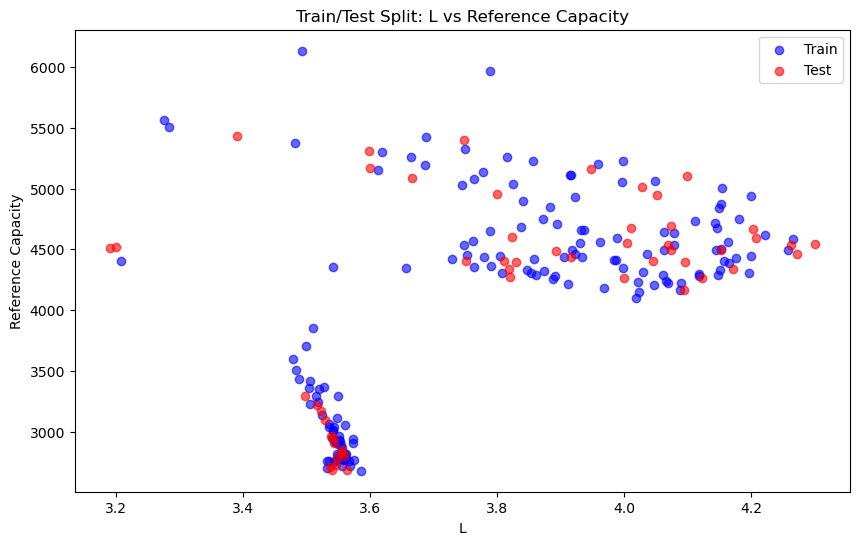

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features (X) and target (y)
y = n_all["Reference Capacity"]  # Target
X = n_all.drop('Reference Capacity', axis = 1) # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot training points in blue
plt.scatter(X_train['L'], y_train, color="blue", label="Train", alpha=0.6)

# Plot testing points in red
plt.scatter(X_test['L'], y_test, color="red", label="Test", alpha=0.6)

# Add labels, legend, and title
plt.xlabel("L")
plt.ylabel("Reference Capacity")
plt.title("Train/Test Split: L vs Reference Capacity")
plt.legend()
plt.show()

In [14]:
print(X_train.shape, y_train.shape)
print('\n', X_test.shape, y_test.shape)

(155, 4) (155,)

 (52, 4) (52,)


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Polynomial Degree 2": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Linear Regression
  RMSE (folds): [316.43386608295, 297.2345165239118, 1693.900066157924, 312.1122325978035, 356.81230598320974]
  MAE (folds): [228.07787701825887, 249.77788256231105, 471.989629448804, 251.03536940115927, 244.51309855717275]
  Average RMSE: 595.2986
  Average MAE: 289.0788
--------------------------------------------------
Evaluating: Ridge Regression
  RMSE (folds): [317.4938928214079, 297.1797365413422, 998.5702358035014, 314.5444576930318, 352.51615441499024]
  MAE (folds): [228.16311294010674, 250.22843805097185, 361.0203156453492, 252.41651975739703, 241.76383600642225]
  Average RMSE: 456.0609
  Average MAE: 266.7184
--------------------------------------------------
Evaluating: Lasso Regression
  RMSE (folds): [316.4945549992761, 297.2206808481494, 1679.8202559844956, 312.1431463036345, 356.61624438821684]
  MAE (folds): [228.01986212031912, 249.75500329146075, 468.371162867035, 251.05943431095696, 244.36338498621038]
  Average RMSE: 592.4590
  Aver

In [17]:
models.keys()

dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Polynomial Degree 2'])

In [18]:
models['Elastic Net'].coef_

array([  23.45935   , -545.13434284,  158.89973205, -402.8341943 ])

In [19]:
models['Elastic Net'].intercept_

4089.3020532664445

In [20]:
X_train_scaled

array([[-9.56513478e-01,  7.22430386e-01, -8.39398537e-01,
         8.92361997e-01],
       [-9.74986536e-01,  7.30158453e-01, -8.43538079e-01,
         1.10242444e+00],
       [-9.42469552e-01,  8.89098035e-01, -8.07362044e-01,
         1.10110127e+00],
       [ 5.62530485e-01,  1.73780778e-01,  3.22486900e-02,
        -6.95153562e-01],
       [ 1.46579145e+00,  2.81309024e-01,  1.64155553e+00,
        -7.82197148e-01],
       [ 1.63463232e+00,  5.33256756e-01,  2.82442668e+00,
        -8.83495167e-01],
       [-1.21453083e+00,  4.74648920e-01, -8.48619352e-01,
         1.32517369e+00],
       [ 4.81480483e-01, -3.48903574e-02, -1.10121150e-01,
        -5.65588338e-01],
       [-9.23330852e-01,  8.00533426e-01, -8.14393241e-01,
         1.06240704e+00],
       [ 3.98908166e-01, -1.20163086e-01, -1.65945467e-01,
        -5.62970162e-01],
       [ 1.09843030e+00,  8.33331960e-01,  4.66322581e-01,
        -6.88815178e-01],
       [ 6.72228493e-01, -8.22181697e-01,  7.28788250e-01,
      

In [21]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Models to evaluate
models = {
    "SVM with RBF Kernel": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: SVM with RBF Kernel
  RMSE (folds): [804.8684871800485, 935.1405345503563, 843.5741710484562, 947.3128036105567, 882.6542928659495]
  MAE (folds): [599.7861271065622, 736.4106193950618, 654.0099343237741, 743.3266741037661, 713.0839163813887]
  Average RMSE: 882.7101
  Average MAE: 689.3235
--------------------------------------------------
Evaluating: Decision Tree
  RMSE (folds): [382.5158806038372, 295.4583669072787, 279.8009160096491, 284.05701696734604, 312.7786492087315]
  MAE (folds): [189.3029677419354, 190.29867741935482, 184.11209677419356, 169.55883870967745, 207.1827096774194]
  Average RMSE: 310.9222
  Average MAE: 188.0911
--------------------------------------------------
Evaluating: Random Forest
  RMSE (folds): [243.34430689201994, 180.94314262861747, 269.1498184634068, 239.64266507602255, 303.2508580777315]
  MAE (folds): [145.20865548386988, 134.1261745161289, 197.8260509677418, 142.04934387096878, 173.3245645161303]
  Average RMSE: 247.2662
  Average MAE

In [22]:
from sklearn.model_selection import GridSearchCV
import joblib  # To save the model

# Models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Hyperparameter grids
param_grids = {

    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, param_grid, X, y):
    rmse_scores = []
    mae_scores = []
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    
    # Save the best model for Random Forest
    if isinstance(best_model, RandomForestRegressor):
        joblib.dump(best_model, 'best_random_forest_model.joblib')
        print("Best Random Forest model saved as 'best_random_forest_model.joblib'")

    # Save the best model for Decision Tree
    if isinstance(best_model, DecisionTreeRegressor):
        joblib.dump(best_model, 'best_decision_tree_model.joblib')
        print("Best Decision Tree model saved as 'best_decision_tree_model.joblib'")
    
    # Evaluate the best model using cross-validation
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        best_model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Get the hyperparameter grid for the model
    param_grid = param_grids[name]
    
    # Evaluate the model with hyperparameter tuning
    rmse_scores, mae_scores = evaluate_model(model, param_grid, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Decision Tree
Best parameters for DecisionTreeRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Decision Tree model saved as 'best_decision_tree_model.joblib'
  RMSE (folds): [322.14546280538, 285.05147511715217, 277.3165369953784, 270.9237481385793, 256.575479149812]
  MAE (folds): [174.9151102150538, 190.8912392473119, 200.0675779569892, 160.50368548387107, 177.52183870967735]
  Average RMSE: 282.4025
  Average MAE: 180.7799
--------------------------------------------------
Evaluating: Random Forest
Best parameters for RandomForestRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest model saved as 'best_random_forest_model.joblib'
  RMSE (folds): [233.54915251693922, 180.98850781341568, 272.07706255888394, 227.15678959550013, 282.7703164423884]
  MAE (folds): [148.60287724044596, 129.86596188226756, 203.24789912618124, 136.19513053062067, 17

In [23]:
models['Random Forest'].fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [24]:
testpred = models['Random Forest'].predict(X_test_scaled)

In [25]:
import numpy as np

In [26]:
4.8,11,31

(4.8, 11, 31)

In [27]:
xnew = X_test*np.random.normal([1,1,1,1],[.04,.08,.11,.31])

In [28]:
xnew - X_test

L         A        x0         b
22  0.081000  0.108649 -5.360579  0.048355
15  0.067768  0.111068 -0.428012  0.160698
3   0.065313  0.066625 -0.370409  0.093826
26  0.078409  0.113299 -2.730266  0.054878
27  0.082146  0.113508 -6.369461  0.049126
9   0.067402  0.110563 -0.424588  0.162235
30  0.077958  0.112260 -2.305399  0.056461
65  0.072264  0.091256 -1.042857  0.073115
18  0.067987  0.110807 -0.428718  0.153380
9   0.078987  0.101623 -4.900243  0.045250
32  0.078511  0.100420 -4.193081  0.051470
30  0.068265  0.111700 -0.438288  0.145271
16  0.078084  0.099181 -3.557364  0.047898
66  0.061473  0.036478 -0.312876  0.433254
55  0.073575  0.095364 -1.177685  0.067437
57  0.073809  0.082475 -1.375820  0.065232
25  0.081069  0.109769 -5.303754  0.049672
50  0.079438  0.103455 -3.773302  0.055319
14  0.070637  0.084665 -0.788569  0.066554
5   0.069339  0.081323 -0.657277  0.068155
54  0.073431  0.095980 -1.238613  0.067999
31  0.082334  0.114574 -6.546687  0.049924
34  0.073669  0.097661 -1.179041  0.064403
31  0.078923  0.116735 -2.762776  0.055830
69  0.068209  0.113214 -0.469290  0.163918
25  0.068244  0.112344 -0.426269  0.150960
25  0.077166  0.108795 -2.148579  0.056482
16  0.067865  0.111287 -0.424166  0.159246
2   0.072208  0.077207 -1.392469  0.051780
45  0.080370  0.106292 -4.491188  0.053699
15  0.077612  0.096554 -3.500037  0.047743
68  0.068152  0.112210 -0.472610  0.165697
66  0.068357  0.112687 -0.478290  0.163904
50  0.078886  0.116164 -2.615377  0.057953
8   0.076066  0.090987 -2.614660  0.047659
28  0.078504  0.114519 -2.712998  0.055688
68  0.073618  0.095236 -1.198810  0.069146
28  0.082857  0.116314 -7.485322  0.048603
45  0.068588  0.112834 -0.446929  0.142774
43  0.077060  0.110056 -1.906767  0.059545
65  0.068475  0.113780 -0.491767  0.162846
38  0.080032  0.104956 -4.415507  0.052492
16  0.073214  0.094517 -1.215128  0.059187
63  0.077285  0.095473 -3.152616  0.058357
67  0.068327  0.112289 -0.469119  0.165327
12  0.069370  0.080792 -0.753717  0.070801
65  0.061643  0.036683 -0.012377  0.798987
54  0.075014  0.086474 -1.760897  0.060544
38  0.068507  0.113252 -0.446548  0.149415
24  0.068180  0.111743 -0.424034  0.150958
60  0.068652  0.114301 -0.485386  0.152668
55  0.075470  0.089047 -1.804601  0.060468

In [29]:
xnew = scaler.transform(xnew)

In [30]:
testprednew = models['Random Forest'].predict(xnew)
testprednew

array([4364.92822, 2903.09992, 5517.75788, 4198.3266 , 4370.03281,
       2909.21974, 4192.47884, 4372.41469, 2903.09992, 4511.13667,
       4274.91028, 2926.54657, 4345.00968, 4025.60308, 4301.68759,
       4492.92506, 4348.50707, 4204.91542, 4626.19548, 4824.0543 ,
       4302.26723, 4322.43817, 4310.28772, 4200.76413, 2795.10275,
       2927.87817, 4192.32675, 2903.09992, 5012.22261, 4220.04472,
       4342.31533, 2795.23774, 2797.54537, 4197.72337, 4529.86906,
       4199.76734, 4290.16153, 4374.34913, 2888.56217, 4179.23227,
       2809.98001, 4225.85348, 4317.8313 , 4207.38227, 2795.10275,
       4814.0832 , 4025.60308, 4419.83838, 2886.41111, 2927.87817,
       2798.81143, 4301.51685])

In [31]:
testpred

array([4730.27113, 3208.8946 , 5497.15144, 4426.68647, 4580.73761,
       3453.23295, 4398.39626, 4565.04744, 3219.31897, 4929.24613,
       4627.26671, 2961.98962, 4903.15115, 4025.60308, 4387.32452,
       4765.88925, 4593.53286, 4361.21355, 5006.98158, 5095.89493,
       4370.77694, 4579.03107, 4446.63284, 4381.50016, 2833.85159,
       3038.08195, 4457.98747, 3128.73681, 5286.12567, 4370.31693,
       4933.56249, 2996.28011, 2890.48917, 4258.7443 , 5122.39332,
       4429.12295, 4393.89429, 4621.28244, 2800.37641, 4275.96347,
       2840.2554 , 4498.09026, 4851.60411, 4396.00945, 2882.90834,
       4993.03473, 4025.60308, 4604.91959, 2829.27091, 3046.86478,
       2824.38347, 4554.68586])

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

In [33]:
mean_absolute_percentage_error(testpred, testprednew)

0.04997658243128681

DecisionTreeRegressor(random_state=42) 162.69968127285458
RandomForestRegressor(random_state=42) 154.04235606044523
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 117.0665729650104


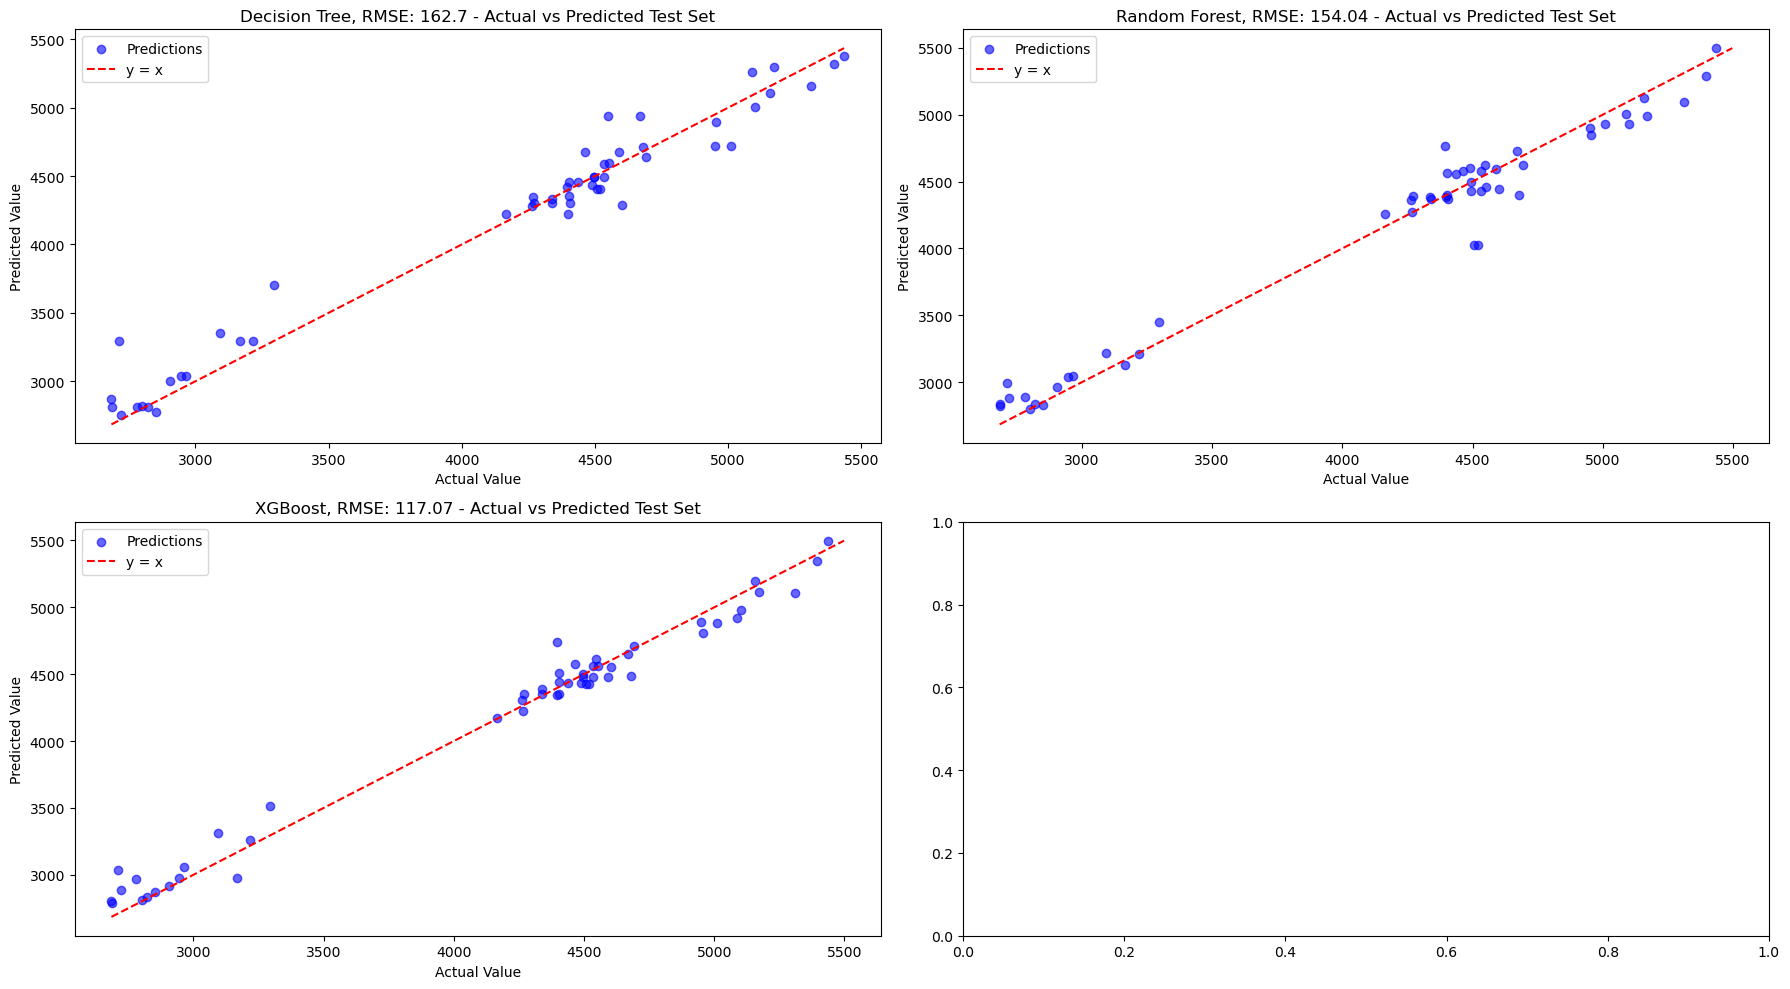

In [34]:
# Define the feature names
features = ['L', 'A', 'x0', 'b']

# Create a subplot grid (1x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# List to store RMSE values for each model
rmse_values = []

# Convert y_test to numpy for plotting
y_test_np = y_test.to_numpy()

# Fit each model, extract coefficients, and plot
for i, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Calculate RMSE for the current model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    rmse_values.append(rmse)

    print(model, rmse)

    # Plot Actual vs Predicted
    axes[i].scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    
    # Plot the "actual = predicted" line (y = x line)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = x")
    
    # Set titles and labels
    axes[i].set_title(f'{name}, RMSE: {rmse.round(2)} - Actual vs Predicted Test Set')
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [35]:
# List to store percentage RMSE values
percent_rmse_values = {}

# Convert y_test to numpy for easier handling
y_test_np = y_test.to_numpy()

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    # Calculate percentage RMSE
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100
    
    # Store the percentage RMSE
    percent_rmse_values[name] = percent_rmse

# Print out the percentage RMSE for each model
for name, percent_rmse in percent_rmse_values.items():
    print(f"{name} - Percentage RMSE: {percent_rmse:.2f}%")

Decision Tree - Percentage RMSE: 3.92%
Random Forest - Percentage RMSE: 3.71%
XGBoost - Percentage RMSE: 2.82%


In [36]:
features

['L', 'A', 'x0', 'b']

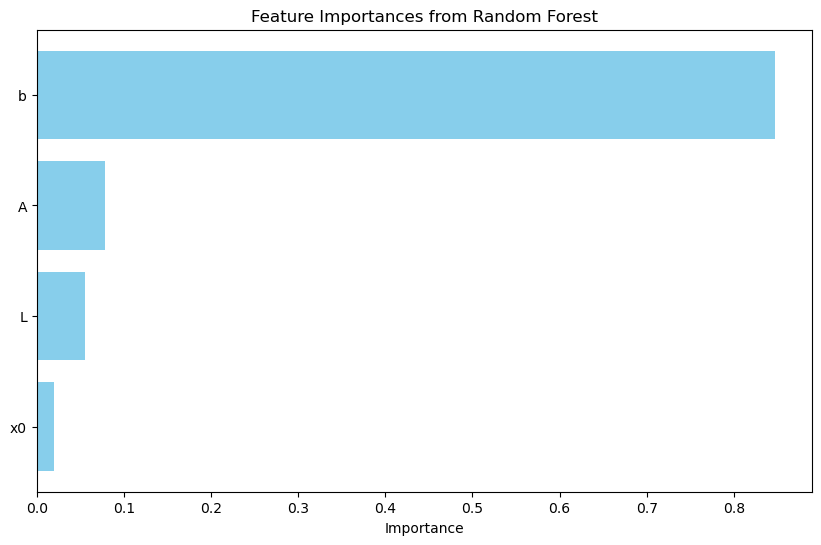

In [37]:
best_model = joblib.load('best_random_forest_model.joblib')

# Get feature importances from the model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization (optional, but can make it easier to view)
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances by value
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.savefig('random_forest_nasa.png')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

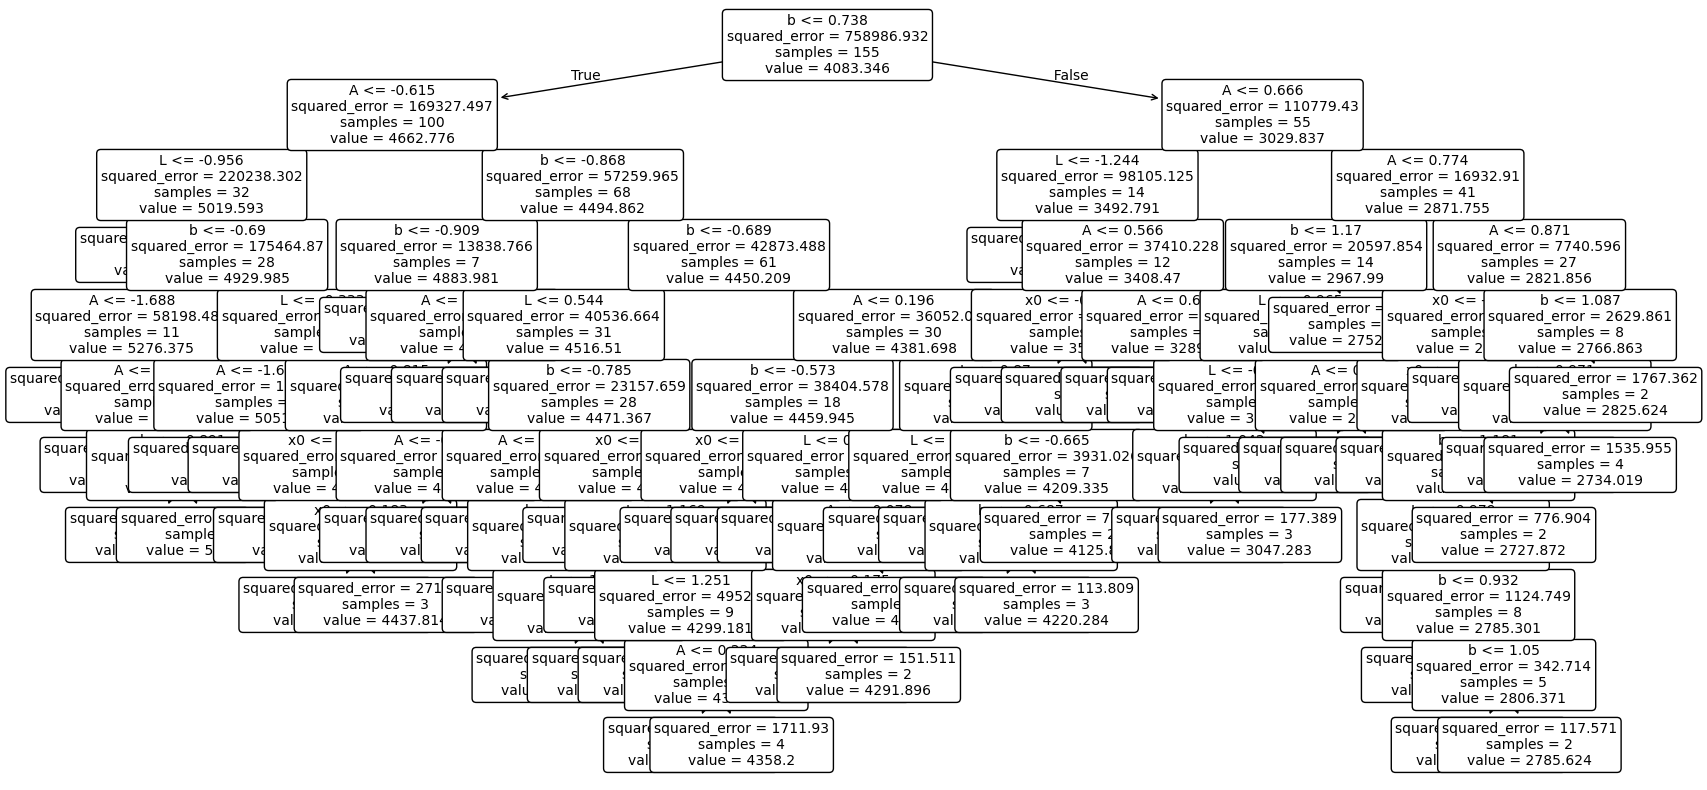

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the model
best_model = joblib.load('best_decision_tree_model.joblib')

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model, 
          feature_names=features,  # Replace with your feature names
          # class_names=['class1', 'class2'],  # Replace with your class names if classification
          filled=False, 
          rounded=True, 
          fontsize=10)
plt.show()

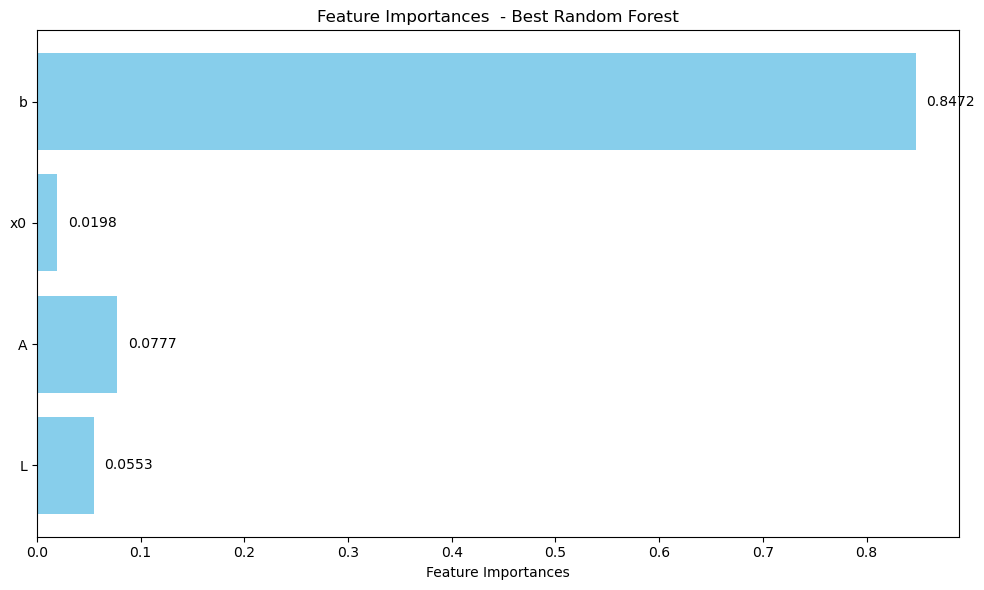

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importances')
plt.title('Feature Importances  - Best Random Forest')

# Annotate the plot with the actual coefficients
for i, (coef, feature) in enumerate(zip(importances, features)):
    plt.text(importances[i] + 0.01, i, f'{coef:.4f}', va='center')

plt.tight_layout()
plt.show()